# Bilibili视频网站排行榜评分的线性回归分析

Bilibili（哔哩哔哩）是当下最热门的视频播放网站，人们在该网站对视频进行浏览，会根据自己喜好对视频进行点赞、投币、收藏、分享、回复等操作，Bilibili同时还有一个排行榜机制，记录了近期比较热门的视频，并给出了一个评分，排行榜的排序规则即根据该评分，本文将根据这些排行榜视频的各项数据，进行线性回归分析，结合实际情况找出对评分影响最大的数据。

Bilibili提供了获取排行榜数据的API，因此我们可以利用该API获取实时的排行榜数据，获取的数据为json格式，经过解析，已将数据保存至Bilibili.csv文件中。

本文的思路即为多元线性回归，在统计学中，线性回归（linear regression）是利用称为线性回归方程的最小二乘函数对一个或多个自变量和因变量之间关系进行建模的一种回归分析。这种函数是一个或多个称为回归系数的模型参数的线性组合。只有一个自变量的情况称为简单回归，大于一个自变量情况的叫做多元回归（multivariable linear regression）。

完成了对各个自变量权重的计算，找出了对评分影响权重最高的因素，并得到了验证。

在哔哩哔哩官网首页处获取排行榜信息的API，得到为

https://api.bilibili.com/x/web-interface/ranking/v2?rid=0

请求参数为
- rid 分类，0代表全部分类

返回格式为json格式，json中的data字段为视频信息数组。

为了防止请求次数过多增加服务器压力，导致本机IP禁止访问哔哩哔哩，先将请求的response保存到data.txt文件中。

使用python的json包进行解析
```json
{
"aid": 375696064,
"videos": 1,
"tid": 17,
"tname": "单机游戏",
"copyright": 1,
"pic": "http://i0.hdslb.com/bfs/archive/85005893d4c4959ff096d6fb061040e223842bcb.jpg",
"title": "史上最骚魔法师！(第二集)",
"pubdate": 1621566911,
"ctime": 1621566912,
"desc": "本期请到了Warma参与配音！鼓掌！！！！！\n游戏：Darkside Detective\n第一集：BV1M64y1m7gA\n各位如果看得开心，希望三连支持一下！",
"state": 0,
"duration": 658,
"mission_id": 24025,
"rights": {
"bp": 0,
"elec": 0,
"download": 0,
"movie": 0,
"pay": 0,
"hd5": 0,
"no_reprint": 1,
"autoplay": 1,
"ugc_pay": 0,
"is_cooperation": 0,
"ugc_pay_preview": 0,
"no_background": 0
},
"owner": {
"mid": 546195,
"name": "老番茄",
"face": "http://i0.hdslb.com/bfs/face/bc5ca101313d4db223c395d64779e76eb3482d60.jpg"
},
"stat": {
"aid": 375696064,
"view": 1149043,
"danmaku": 7300,
"reply": 3278,
"favorite": 37490,
"coin": 98319,
"share": 1780,
"now_rank": 0,
"his_rank": 1,
"like": 210211,
"dislike": 0
},
"dynamic": "用魔法击败魔法",
"cid": 341808079,
"dimension": {
"width": 1920,
"height": 1080,
"rotate": 0
},
"short_link": "https://b23.tv/BV1jo4y117Vf",
"short_link_v2": "https://b23.tv/BV1jo4y117Vf",
"bvid": "BV1jo4y117Vf",
"score": 2446535
}
```

通过解析json格式文件并整理得到bilibili.csv

In [327]:
# 包引用
import pandas as pd # csv文件读写分析
import numpy as np  # 线性代数
import matplotlib.pyplot as plt # 制图

In [328]:
data = pd.read_csv('./bilibili.csv', index_col='title')

# 评分
score = data['score'] 
# 播放量
view = data['view'] 
# 投币
coins = data['coins']
# 收藏
favor = data['favorite']
# 评论
reply = data['reply']
# 点赞
like = data['like']
# 弹幕数量
danmu = data['danmu']
# 分享次数
share = data['share']

In [329]:
data

,author,rank,score,view,coins,favorite,reply,danmu,share,like
title,,,,,,,,,,
店里卖898一份的招牌菜，自己在家做，居然只花了…,绵羊料理,1,3006938,2503262,182774,35061,3078,9534,6084,291180
《原神》角色演示-「优菈：闪灼的烛光」,原神,2,2627422,2473591,82268,38570,33272,28401,53464,154201
【郎朗】海 上 东 北 钢 琴 师,_青红造了个白_,2,2375678,1744482,238742,104817,5823,4985,39047,301418
禁 忌 女 孩 我 不 更 了！,我是影Sir,4,2231527,1949335,74270,18197,5298,3297,6969,186835
超级变变变,设计师深海,5,2131843,1297760,48405,30526,1103,706,1101,175602
...,...,...,...,...,...,...,...,...,...,...
这就是文理科的神仙对线吗【建议收藏】,进击的金厂长,6,724873,555489,63216,34641,3790,1108,7339,148399
自从这群歪果仁中式骚操作学废了以后。。。,歪果仁研究协会,97,722521,494345,7690,1966,1709,2563,290,45939
10年经典米其林三星 薯条 复刻出来会是什么味道,澳洲阿彭,17,719924,502126,43318,25766,808,982,3127,85044


部分数据展示

In [330]:
score

title
店里卖898一份的招牌菜，自己在家做，居然只花了…     3006938
《原神》角色演示-「优菈：闪灼的烛光」           2627422
【郎朗】海 上 东 北 钢 琴 师             2375678
禁 忌 女 孩 我 不 更 了！              2231527
超级变变变                         2131843
                               ...   
这就是文理科的神仙对线吗【建议收藏】             724873
自从这群歪果仁中式骚操作学废了以后。。。           722521
10年经典米其林三星 薯条 复刻出来会是什么味道       719924
高 ping 玩 家 现 状                 718599
马上生二胎？up主还能做多久？我不想面对这些问题！！     708584
Name: score, Length: 100, dtype: int64

In [331]:
coins

title
店里卖898一份的招牌菜，自己在家做，居然只花了…     182774
《原神》角色演示-「优菈：闪灼的烛光」            82268
【郎朗】海 上 东 北 钢 琴 师             238742
禁 忌 女 孩 我 不 更 了！               74270
超级变变变                          48405
                               ...  
这就是文理科的神仙对线吗【建议收藏】             63216
自从这群歪果仁中式骚操作学废了以后。。。            7690
10年经典米其林三星 薯条 复刻出来会是什么味道       43318
高 ping 玩 家 现 状                  2929
马上生二胎？up主还能做多久？我不想面对这些问题！！     61909
Name: coins, Length: 100, dtype: int64

In [332]:
favor

title
店里卖898一份的招牌菜，自己在家做，居然只花了…      35061
《原神》角色演示-「优菈：闪灼的烛光」            38570
【郎朗】海 上 东 北 钢 琴 师             104817
禁 忌 女 孩 我 不 更 了！               18197
超级变变变                          30526
                               ...  
这就是文理科的神仙对线吗【建议收藏】             34641
自从这群歪果仁中式骚操作学废了以后。。。            1966
10年经典米其林三星 薯条 复刻出来会是什么味道       25766
高 ping 玩 家 现 状                  3148
马上生二胎？up主还能做多久？我不想面对这些问题！！     16301
Name: favorite, Length: 100, dtype: int64

In [333]:
x = [i for i in range(len(score))]
# 获取自变量矩阵
X = data.iloc[:,3:10].values
# 获取因变量矩阵
Y = data.iloc[:,2].values.reshape(-1,1)
# 生成设计矩阵
om = np.ones(X.shape[0]).reshape(-1,1)
X = np.hstack((X, om))

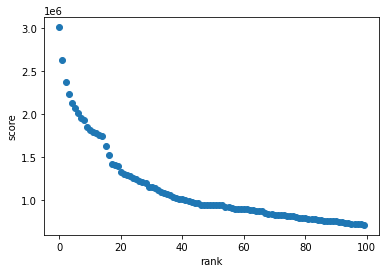

In [334]:
# 绘制图像，按照排名递减绘制，即分数从高到低
plt.xlabel('rank')
plt.ylabel('score')
plt.plot(x, score, 'o')

排名-总分图，总分与rank正相关。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd01d9ac70>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd01e28340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd01d9a940>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd01e289a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd01e35040>],
 'means': [<matplotlib.lines.Line2D at 0x7fcd01e28cd0>]}

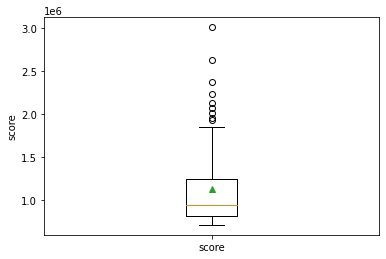

In [335]:
labels = ['score']
plt.ylabel('score')
plt.boxplot(score, labels = labels, showmeans = True)

由箱线图可以得到score数据中，均值大致为120000

中位数大致为900000

使用numpy自带库函数检验

In [336]:
np.mean(score)

1122688.4

In [337]:
np.median(score)

941970.0

In [338]:
np.var(score)

212928036197.18

In [339]:
np.std(score)

461441.2597473052

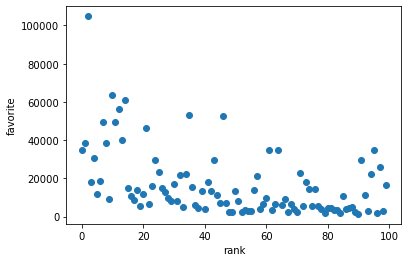

In [340]:
plt.xlabel('rank')
plt.ylabel('favorite')
plt.plot(x, favor, 'o')

根据排名-收藏图，可以发现，收藏对于排名即总分，有一定的正相关。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fccf0f84bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fccf0f922b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fccf0f84850>],
 'medians': [<matplotlib.lines.Line2D at 0x7fccf0f92970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd1171e070>],
 'means': [<matplotlib.lines.Line2D at 0x7fccf0f92cd0>]}

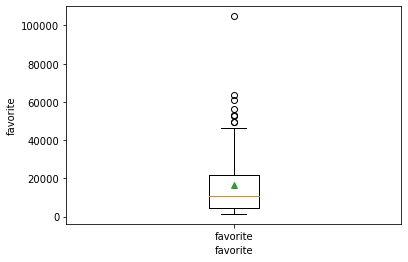

In [341]:
plt.xlabel('favorite')
labels = ['favorite']
plt.ylabel('favorite')
plt.boxplot(favor, labels = labels, showmeans = True)

由箱线图可知，收藏数据集中在[6000, 20000]内，中位数大致为10000，均值为16000

In [342]:
np.mean(favor)

16578.47

In [343]:
np.median(favor)

10722.0

In [344]:
np.var(favor)

302357416.2890999

In [345]:
np.std(favor)

17388.427654307903

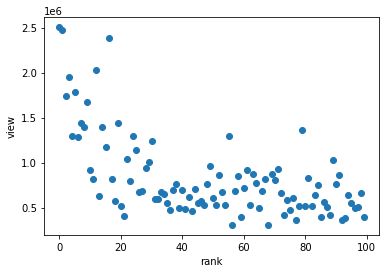

In [346]:
plt.xlabel('rank')
plt.ylabel('view')
plt.plot(x, view, 'o')

通过排名-播放量图，可以得出播放量与排名在一定程度上为正相关。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd01dc82b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd01dc8970>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd01db6f10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd01dd4070>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd01dd4730>],
 'means': [<matplotlib.lines.Line2D at 0x7fcd01dd43d0>]}

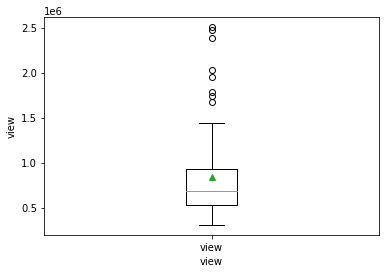

In [347]:
plt.xlabel('view')
labels = ['view']
plt.ylabel('view')
plt.boxplot(view, labels = labels, showmeans = True)

由箱线图可知，播放量数据集中在[600000, 800000]内，中位数大致为600000，均值大致为800000

In [348]:
np.mean(view)

835744.33

In [349]:
np.median(view)

681824.5

In [350]:
np.var(view)

213601199487.2411

In [351]:
np.std(view)

462170.09800206794

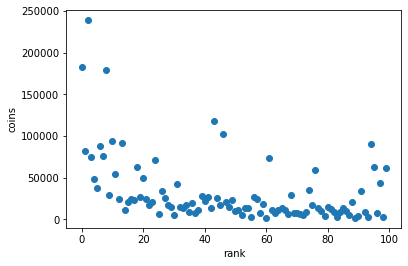

In [352]:
plt.xlabel('rank')
plt.ylabel('coins')
plt.plot(x, coins, 'o')

通过排名-投币数图，可以得出排名与投币数在一定程度上为正相关。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fccf11f6bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fccf12042b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fccf11f6850>],
 'medians': [<matplotlib.lines.Line2D at 0x7fccf1204970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fccf1204fd0>],
 'means': [<matplotlib.lines.Line2D at 0x7fccf1204ca0>]}

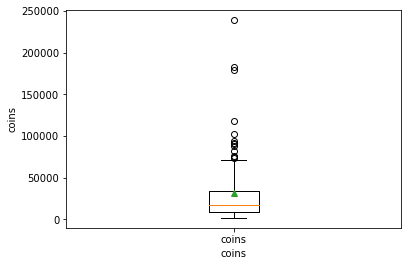

In [353]:
plt.xlabel('coins')
labels = ['coins']
plt.ylabel('coins')
plt.boxplot(coins, labels = labels, showmeans = True)

由箱线图可知，投币数据集中在[15000, 30000]内，中位数大致为17000，均值大致为30000

In [354]:
np.mean(coins)

31900.79

In [355]:
np.median(coins)

17495.5

In [356]:
# 方差
np.var(coins)

1563604214.445899

In [357]:
# 标准差
np.std(coins)

39542.43561600498

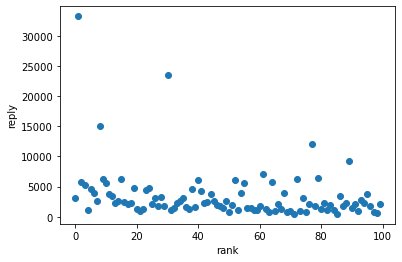

In [358]:
plt.xlabel('rank')
plt.ylabel('reply')
plt.plot(x, reply, 'o')

通过排名-评论数图，可以得出排名与评论数相关性较低。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd246a7310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd246a79d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd24698f70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd246b40d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd246b4790>],
 'means': [<matplotlib.lines.Line2D at 0x7fcd246b4430>]}

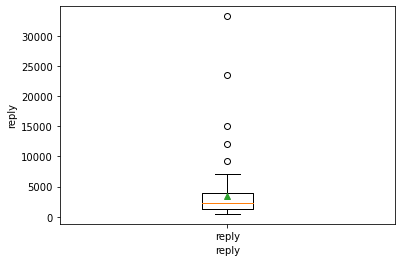

In [359]:
plt.xlabel('reply')
labels = ['reply']
plt.ylabel('reply')
plt.boxplot(reply, labels = labels, showmeans = True)

由箱线图可知，评论数据集中在[2500, 4000]内，中位数大致为2500，均值大致为3000

In [360]:
np.mean(reply)

3424.87

In [361]:
np.median(reply)

2223.5

In [362]:
# 方差
np.var(reply)

18640762.053099994

In [363]:
# 标准差
np.std(reply)

4317.494881653016

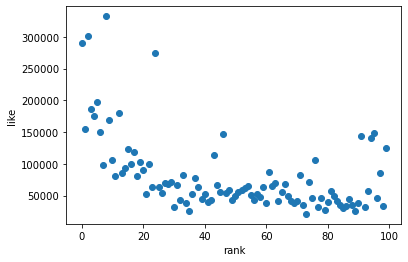

In [364]:
plt.xlabel('rank')
plt.ylabel('like')
plt.plot(x, like, 'o')

通过排名-点赞数图，可以得出排名与点赞数在一定程度上为正相关。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd11a073a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd11a07a60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd119f8fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd11a14160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd11a147f0>],
 'means': [<matplotlib.lines.Line2D at 0x7fcd11a144c0>]}

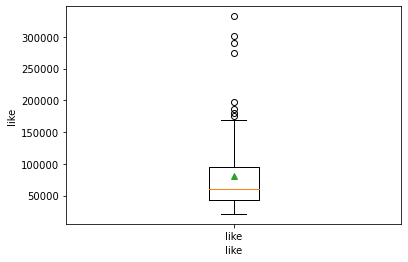

In [365]:
plt.xlabel('like')
labels = ['like']
plt.ylabel('like')
plt.boxplot(like, labels = labels, showmeans = True)

由箱线图可知，点赞数据集中在[50000, 100000]内，中位数大致为60000,均值大致为80000

In [366]:
np.mean(like)

80874.31

In [367]:
np.median(like)

60506.0

In [368]:
# 方差
np.var(like)

3598569720.5339003

In [369]:
# 标准差
np.std(like)

59988.079820360144

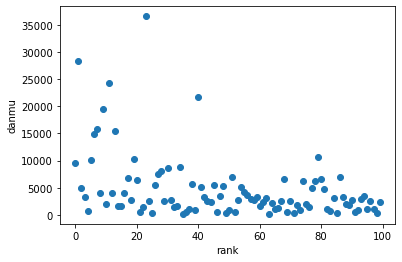

In [370]:
plt.xlabel('rank')
plt.ylabel('danmu')
plt.plot(x, danmu, 'o')

通过排名-弹幕数图，可以得出排名与弹幕数相关性较低。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd11a75e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd11a86460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd11a75b20>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd11a86a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd11a92100>],
 'means': [<matplotlib.lines.Line2D at 0x7fcd11a86d90>]}

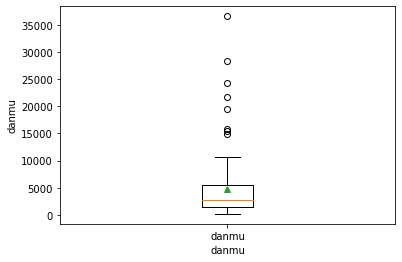

In [371]:
plt.xlabel('danmu')
labels = ['danmu']
plt.ylabel('danmu')
plt.boxplot(danmu, labels = labels, showmeans = True)

由箱线图可知，弹幕数据集中在[2500, 5000]内，中位数大致为2500，均值大致为5000

In [372]:
np.median(danmu)

2724.0

In [373]:
np.mean(danmu)

4772.05

In [374]:
# 方差
np.var(danmu)

36392009.48749998

In [375]:
# 标准差
np.std(danmu)

6032.579007978261

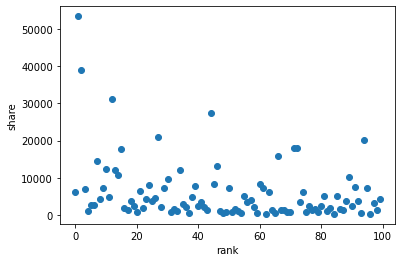

In [376]:
plt.xlabel('rank')
plt.ylabel('share')
plt.plot(x, share, 'o')

通过排名-分享数图，可以得出排名与分享数相关性较低。

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcd114f18b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcd244757c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcd01bf1640>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcd2450af40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcd1170c3d0>],
 'means': [<matplotlib.lines.Line2D at 0x7fcd116d99d0>]}

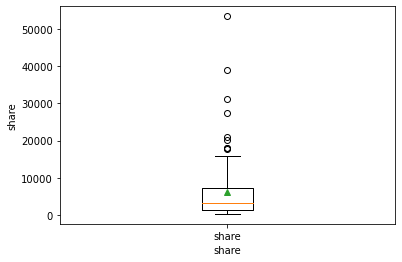

In [377]:
plt.xlabel('share')
labels = ['share']
plt.ylabel('share')
plt.boxplot(share, labels = labels, showmeans = True)

由箱线图可知，分享数据集中在[1000, 6000]内，中位数大致为3000，均值大致为6000

In [378]:
np.median(share)

3328.5

In [379]:
np.mean(share)

6068.27

In [380]:
# 方差
np.var(share)

68479834.8771

In [381]:
# 标准差
np.std(share)

8275.254369329079

In [382]:
# 计算系数矩阵w-hat
w_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
# 获取b矩阵
b = w_hat[-1]
# 获取w系数矩阵
w = w_hat[:-1]

In [383]:
w_hat

array([[ 5.35882458e-01],
       [ 2.01063732e+00],
       [ 5.79443124e+00],
       [-4.91889223e+00],
       [ 1.75152391e+01],
       [-3.73019387e+00],
       [ 8.95374932e-01],
       [ 3.98109914e+05]])

In [384]:
b

array([398109.91437092])

In [385]:
w

array([[ 0.53588246],
       [ 2.01063732],
       [ 5.79443124],
       [-4.91889223],
       [17.51523907],
       [-3.73019387],
       [ 0.89537493]])

这里发现w系数矩阵中出现了负值，经检查发现该项目对应的自变量为like和reply，即视频的点赞次数和评论数，这与实际情况是不符的，猜测是因为该自变量对结果的影响过小，导致预测出现了偏差，同时发现弹幕数量对视频评分的影响过大，远超于其他参数，显然与实际生活不符，并且作为对视频质量的估计，弹幕数也的确不能作为一个重要的参数。

因此我们对弹幕数进行剔除重新进行拟合。

In [386]:
data = pd.read_csv('./bilibili.csv', index_col='title')

In [387]:
# 获取自变量矩阵，剔除弹幕数
X = data.iloc[:,[3, 4, 5, 6, 8, 9]].values
# 获取因变量矩阵
Y = data.iloc[:,2].values.reshape(-1,1)
# 生成设计矩阵
om = np.ones(X.shape[0]).reshape(-1,1)
X = np.hstack((X, om))

In [388]:
# 计算系数矩阵w-hat
w_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
# 获取b矩阵
b = w_hat[-1]
# 获取w系数矩阵
w = w_hat[:-1]

In [389]:
b

array([426773.33411122])

In [390]:
w

array([[ 0.60269881],
       [ 2.82157809],
       [ 5.35461617],
       [ 3.04630747],
       [-3.9125348 ],
       [ 0.33063835]])

观察发现此时各项参数对于评分的影响已经较为接近正常水平。但是share，视频分享数对于评分的影响仍为负值，依然根据上述猜测，share对于总分的影响过小，导致拟合的结果差，因此再次剔除share字段。

In [391]:
# 获取自变量矩阵，剔除弹幕数，分享数
X = data.iloc[:,[3, 4, 5, 6, 9]].values
# 获取因变量矩阵
Y = data.iloc[:,2].values.reshape(-1,1)
# 生成设计矩阵
om = np.ones(X.shape[0]).reshape(-1,1)
X = np.hstack((X, om))

In [392]:
# 计算系数矩阵w-hat
w_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
# 获取b矩阵
b = w_hat[-1]
# 获取w系数矩阵
w = w_hat[:-1]

In [393]:
X_test = data.iloc[:, [3, 4, 5, 6, 9]].values
Y_predict = np.dot(X_test, w) + b

In [394]:
dic = abs(Y-Y_predict)

In [395]:
sum = 0
for i in range(len(Y)):
  sum += abs(Y[i][0] - Y_predict[i][0])

误差的平均值

In [396]:
sum/len(Y)

181348.81788162683

In [397]:
#计算平均平方误差啊
mse = 0
for i in range(len(Y)):
    mse += (Y[i][0] - Y_predict[i][0])**2
mse /= len(Y)

In [398]:
mse

53649810543.205574

In [399]:
len(Y)

100

In [400]:
# 计算平均平方误差平方根
rmse = np.sqrt(mse)

In [401]:
rmse

231624.2874639997

In [402]:
# 计算R^2决定系数
# r^2 = 1 - rss/tss
rss = 0
for i in range(len(Y)):
    rss += (Y[i][0] - Y_predict[i][0])**2

In [403]:
rss

5364981054320.558

In [404]:
mse*len(Y)

5364981054320.558

In [405]:
# 计算tss
tss = 0
y_ = 0 # average y
for i in range(len(Y)):
    y_ += Y[i][0]
y_ = y_ / len(Y)
for i in range(len(Y)):
    tss += (Y[i][0] - y_)**2
R2 = 1 - rss/tss

In [406]:
R2

0.7480378277028598

通过对R^2决定系数的计算，可以发现模型拟合的效果较为良好。

观察预测值与实际值的差距，发现拟合的趋势基本吻合，但仍有较大的误差

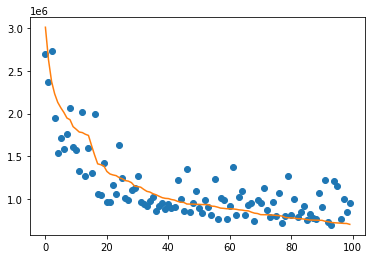

In [407]:
x = [i for i in range(0, len(Y))]
plt.plot(x, Y_predict, 'o')
plt.plot(x, Y)

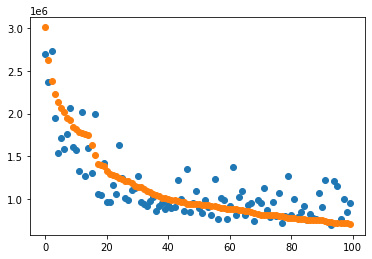

In [408]:
plt.plot(x, Y_predict, 'o')
plt.plot(x, Y, 'o')

从图象中可以看出，预测值的趋势与实际值较为接近。

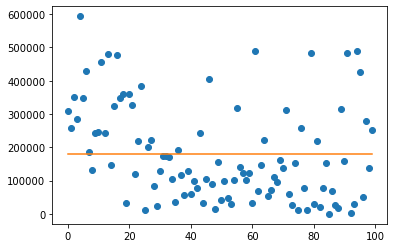

In [409]:
y = [sum/len(Y) for i in range(len(x))]
plt.plot(x, dic, 'o')
plt.plot(x, y)

分析得出，该线性模型的拟合误差较为集中，集中在[0, 181348.81788162683]即平均误差之间。

根据权重分析各个数据对总分的影响，可以发现，收藏对于视频总评分的影响占比最高，其次是硬币数，播放数，说明哔哩哔哩对与视频的质量高低评判有一定的综合考量，播放量属于可以由视频制作人通过其他方式刷取，但是收藏量是由用户对于视频质量的高低做出的决定，因而更具代表性，更有说服力。反观实际观看体验中，有些视频制作人会以视频收藏满几万后，更新新一期视频，因为该项对视频的收益影响最大，更能给视频制作人带来实际收益。

In [410]:
w

array([[0.59149795],
       [2.85961313],
       [4.47955342],
       [0.34492927],
       [0.35243338]])

本次线性回归的拟合可以较为准确的判断出各各数据对于视频评分的影响，但是对于视频评分的预测误差较大，但是仍能较准确的判断出视频评分所影响的视频排名，认为有如下原因：
- 数据量过少，导致拟合程度不足
- 评分规则非线形模型，应该更换模型
- 还有其他未考虑的因素

如果要更准确的对视频评分进行预测，应该综合分析数据的特性，或者采用机器学习等更优秀的手段来进行求解和预测，线性回归仍有一定的局限性。